In [5]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

# Define constants
TRAIN_CSV = "/kaggle/input/computervision/meta.csv"
VALID_CSV = "/kaggle/input/computervision/valid_meta.csv"
TEST_CSV = "/kaggle/input/computervision/test_meta.csv"

# Early Stopping Hyperparameters
PATIENCE = 10  # Number of epochs to wait for improvement
MIN_DELTA = 0.001  # Minimum change in validation loss to qualify as an improvement

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
IMAGE_SIZE = 512
NUM_CLASSES = 5
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Primary GPU

# Ensure multiple GPUs are used
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
else:
    print("Using a single GPU!")

# Modify get_model function to use multiple GPUs
def get_model():
    weights = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_resnet101(weights=weights)

    # Modify classifier for NUM_CLASSES
    model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))

    # Move model to primary GPU
    model = model.to(DEVICE)

    # Use DataParallel for multiple GPUs
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    return model

def train_fn(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    
    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(loader)

def val_fn(model, loader, criterion):
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)
            
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            
            running_loss += loss.item()
    
    return running_loss / len(loader)

def main():
    train_dataset = LandcoverAIDataset(TRAIN_CSV)
    valid_dataset = LandcoverAIDataset(VALID_CSV)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA, path='best_model.pth')

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch: {epoch+1}/{NUM_EPOCHS}")
        torch.cuda.empty_cache()
        
        train_loss = train_fn(model, train_loader, optimizer, criterion)
        val_loss = val_fn(model, valid_loader, criterion)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    model.load_state_dict(torch.load('best_model.pth'))

if __name__ == "__main__":
    main()


Using 2 GPUs!
Loaded 1856 samples from /kaggle/input/computervision/meta.csv
Loaded 200 samples from /kaggle/input/computervision/valid_meta.csv

Epoch: 1/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


Train Loss: 0.8832
Validation Loss: 0.3479
Validation loss decreased (0.347943 --> 0.347943). Saving model ...

Epoch: 2/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


Train Loss: 0.5459
Validation Loss: 0.4512
EarlyStopping counter: 1 out of 10

Epoch: 3/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


Train Loss: 0.4328
Validation Loss: 0.3545
EarlyStopping counter: 2 out of 10

Epoch: 4/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Train Loss: 0.3555
Validation Loss: 0.3126
Validation loss decreased (0.312630 --> 0.312630). Saving model ...

Epoch: 5/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Train Loss: 0.3079
Validation Loss: 0.3196
EarlyStopping counter: 1 out of 10

Epoch: 6/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


Train Loss: 0.2870
Validation Loss: 0.3407
EarlyStopping counter: 2 out of 10

Epoch: 7/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


Train Loss: 0.2487
Validation Loss: 0.2405
Validation loss decreased (0.240544 --> 0.240544). Saving model ...

Epoch: 8/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Train Loss: 0.2422
Validation Loss: 0.3273
EarlyStopping counter: 1 out of 10

Epoch: 9/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Train Loss: 0.2491
Validation Loss: 0.3479
EarlyStopping counter: 2 out of 10

Epoch: 10/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Train Loss: 0.2194
Validation Loss: 0.2493
EarlyStopping counter: 3 out of 10

Epoch: 11/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Train Loss: 0.1810
Validation Loss: 0.2355
Validation loss decreased (0.235543 --> 0.235543). Saving model ...

Epoch: 12/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Train Loss: 0.1896
Validation Loss: 0.2560
EarlyStopping counter: 1 out of 10

Epoch: 13/20


Validation: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


Train Loss: 0.1869
Validation Loss: 0.2650
EarlyStopping counter: 2 out of 10

Epoch: 14/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


Train Loss: 0.1780
Validation Loss: 0.2715
EarlyStopping counter: 3 out of 10

Epoch: 15/20


Validation: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


Train Loss: 0.1992
Validation Loss: 0.3475
EarlyStopping counter: 4 out of 10

Epoch: 16/20


Validation: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


Train Loss: 0.1906
Validation Loss: 0.2199
Validation loss decreased (0.219853 --> 0.219853). Saving model ...

Epoch: 17/20


Validation: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


Train Loss: 0.1363
Validation Loss: 0.2260
EarlyStopping counter: 1 out of 10

Epoch: 18/20


Validation: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Train Loss: 0.1221
Validation Loss: 0.1939
Validation loss decreased (0.193852 --> 0.193852). Saving model ...

Epoch: 19/20


Validation: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


Train Loss: 0.1227
Validation Loss: 0.2115
EarlyStopping counter: 1 out of 10

Epoch: 20/20


Validation: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]
<ipython-input-5-be542fd5b386>:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.loa

Train Loss: 0.1171
Validation Loss: 0.2673
EarlyStopping counter: 2 out of 10


In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

# Define constants
TRAIN_CSV = "/kaggle/input/computervision/meta.csv"
VALID_CSV = "/kaggle/input/computervision/valid_meta.csv"
TEST_CSV = "/kaggle/input/computervision/test_meta.csv"

# Early Stopping Hyperparameters
PATIENCE = 10  # Number of epochs to wait for improvement
MIN_DELTA = 0.001  # Minimum change in validation loss to qualify as an improvement

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
IMAGE_SIZE = 512
NUM_CLASSES = 5
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Primary GPU

# Ensure multiple GPUs are used
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
else:
    print("Using a single GPU!")

# Modify get_model function to use multiple GPUs
def get_model():
    weights = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_resnet101(weights=weights)

    # Modify classifier for NUM_CLASSES
    model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))

    # Move model to primary GPU
    model = model.to(DEVICE)

    # Use DataParallel for multiple GPUs
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    return model

def train_fn(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    
    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(loader)

def val_fn(model, loader, criterion):
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)
            
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            
            running_loss += loss.item()
    
    return running_loss / len(loader)

def main():
    train_dataset = LandcoverAIDataset(TRAIN_CSV)
    valid_dataset = LandcoverAIDataset(VALID_CSV)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA, path='best_model.pth')

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch: {epoch+1}/{NUM_EPOCHS}")
        torch.cuda.empty_cache()
        
        train_loss = train_fn(model, train_loader, optimizer, criterion)
        val_loss = val_fn(model, valid_loader, criterion)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    model.load_state_dict(torch.load('best_model.pth'))




Using 2 GPUs!


In [8]:
import shutil

# Ensure the model is in the correct directory
model_path = "/kaggle/working/best_model.pth"
output_path = "/kaggle/working/best_model.pth"
shutil.move(model_path, output_path)

# Kaggle automatically shows files in '/kaggle/working/' for download
print("Go to the Kaggle file explorer (right panel), find 'best_model.pth' in '/kaggle/working/', and click 'Download'.")


Go to the Kaggle file explorer (right panel), find 'best_model.pth' in '/kaggle/working/', and click 'Download'.


In [2]:
import torch
import numpy as np

def compute_iou(preds, masks, num_classes):
    """
    Compute the mean Intersection over Union (IoU) score.
    
    Args:
        preds (torch.Tensor): Predicted segmentation masks (batch_size, H, W).
        masks (torch.Tensor): Ground truth segmentation masks (batch_size, H, W).
        num_classes (int): Number of classes.

    Returns:
        float: Mean IoU score.
    """
    iou_per_class = []

    for cls in range(num_classes):
        pred_mask = (preds == cls)  # Pixels predicted as class 'cls'
        true_mask = (masks == cls)  # Ground truth pixels for class 'cls'

        intersection = torch.logical_and(pred_mask, true_mask).sum().item()
        union = torch.logical_or(pred_mask, true_mask).sum().item()

        if union == 0:
            iou_per_class.append(float('nan'))  # Ignore classes not present
        else:
            iou_per_class.append(intersection / union)

    # Compute mean IoU while ignoring NaN values
    mean_iou = np.nanmean(iou_per_class) * 100  # Convert to percentage
    return mean_iou

In [3]:
import sys

In [5]:
# Define colors for visualization
COLORS = [
    (0, 0, 0),         # Background (black)
    (128, 0, 0),       # Building (maroon)
    (0, 128, 0),       # Woodland (green)
    (0, 0, 128),       # Water (navy)
    (128, 128, 0),     # roads (olive)
]

In [7]:


def visualize_prediction(model, dataset, idx):
    model.eval()
    
    # Free up GPU memory before visualization
    torch.cuda.empty_cache()
    
    image, mask = dataset[idx]
    image_viz = image.permute(1, 2, 0).cpu().numpy()
    image_viz = np.clip(image_viz, 0, 1)
    
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(DEVICE)
        output = model(input_tensor)["out"]
        output = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    # Create color visualizations
    mask_viz = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    pred_viz = np.zeros((output.shape[0], output.shape[1], 3), dtype=np.uint8)
    
    for class_idx, color in enumerate(COLORS):
        mask_viz[mask.cpu().numpy() == class_idx] = color
        pred_viz[output == class_idx] = color
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_viz)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_viz)
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_viz)
    plt.title("Prediction")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()


Loaded 1602 samples from /kaggle/input/computervision/test_meta.csv


<ipython-input-8-1037233de37e>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/computervision/best_model(7).pth", map_locat

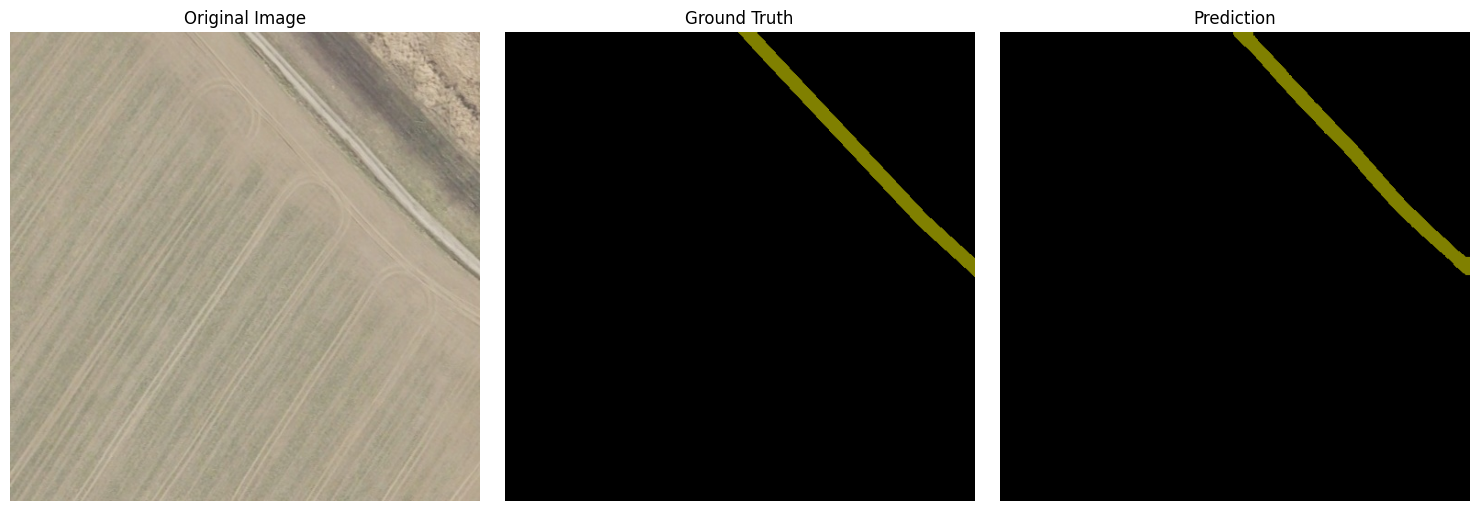

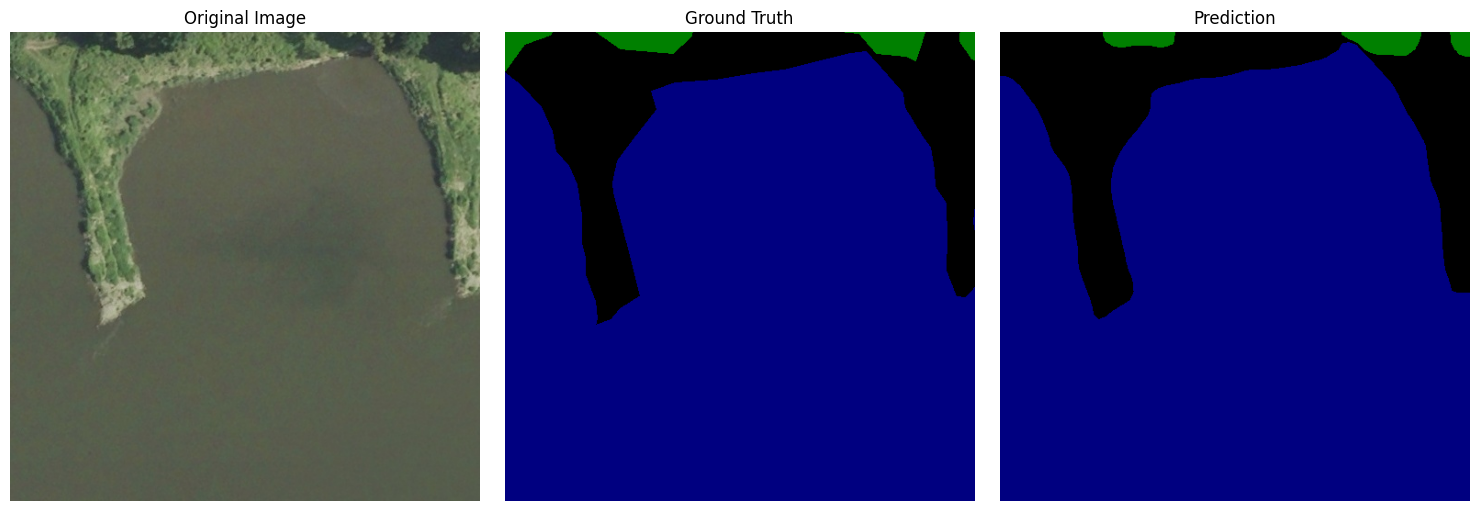

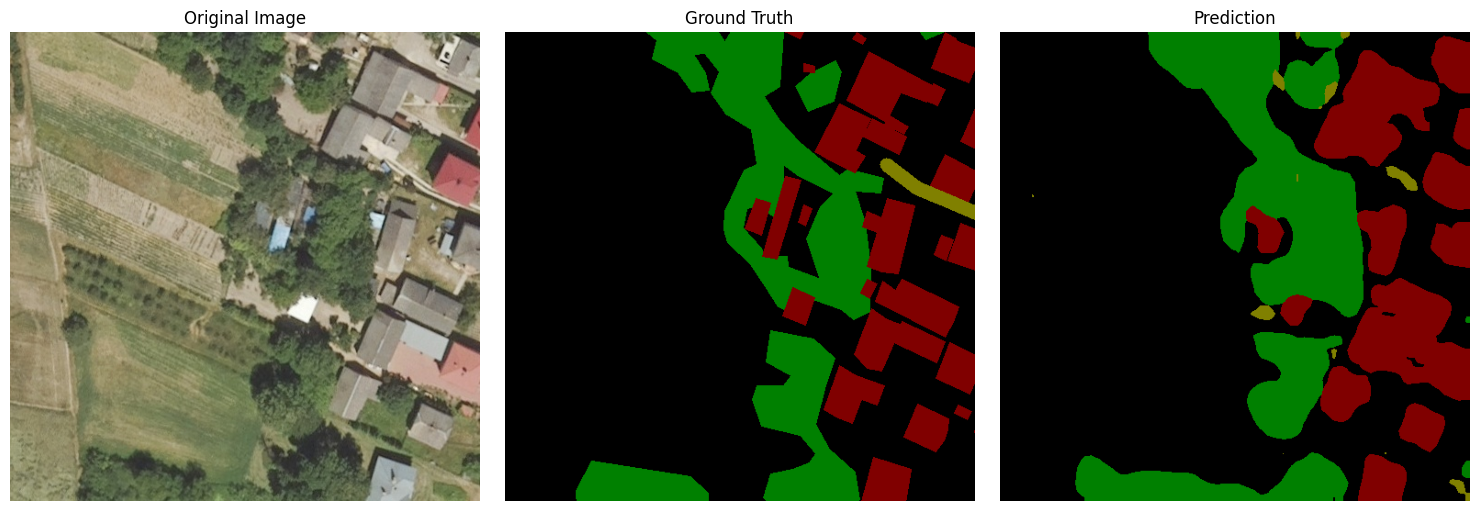

Testing:   0%|          | 0/401 [00:01<?, ?it/s]

torch.Size([4, 5, 512, 512])
tensor([[[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]],

        [[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]],

        [[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]],

        [[0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 2, 2, 2],
         ...,
         [0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 2, 2, 2]]], device='cuda:0')


SystemExit: Okay

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import DataLoader

# Load test dataset


class LandcoverAIDataset(Dataset):
    def __init__(self, csv_file):
        # Read CSV file
        self.data = pd.read_csv("/kaggle/input/computervision/test_meta1.csv")
        print(f"Loaded {len(self.data)} samples from {csv_file}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row["image_path"]
        gt_path = row["groundtruth_path"]
        
        # Read image and convert to RGB
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        # Simplified image preprocessing
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        
        # Read ground truth (mask) in grayscale
        mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Ground truth not found: {gt_path}")
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        
        # Convert to tensors with minimal processing
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).long()
        
        return image, mask



# Load the trained model
def load_model():
    model = get_model()  # Get the model architecture
    model.load_state_dict(torch.load("/kaggle/input/computervision/best_model(7).pth", map_location=DEVICE))  # Load weights
    model.eval()  # Set to evaluation mode
    return model

# Compute accuracy and confusion matrix
def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)["out"]
            preds = torch.argmax(outputs, dim=1)  # Get class with highest probability

            print(outputs.shape)

            print(preds)

            sys.exit("Okay")

            all_preds.append(preds.cpu().numpy().flatten())
            all_labels.append(masks.cpu().numpy().flatten())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (%)")
    plt.show()

# Main function
def main():
    test_dataset = LandcoverAIDataset(TEST_CSV)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    model = load_model()
    for i in range(3):
        idx = np.random.randint(0, len(test_dataset))
        visualize_prediction(model, test_dataset, idx)

    
    evaluate_model(model, test_loader)

if __name__ == "__main__":
    main()

In [7]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights

# Define constants
TRAIN_CSV = "/kaggle/input/computervision/meta.csv"
VALID_CSV = "/kaggle/input/computervision/valid_meta.csv"
TEST_CSV = "/kaggle/input/computervision/test_meta.csv"

# Early Stopping Hyperparameters
PATIENCE = 10  # Number of epochs to wait for improvement
MIN_DELTA = 0.001  # Minimum change in validation loss to qualify as an improvement

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
IMAGE_SIZE = 512
NUM_CLASSES = 5
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Define colors for visualization
COLORS = [
    (0, 0, 0),         # Background (black)
    (128, 0, 0),       # Building (maroon)
    (0, 128, 0),       # Woodland (green)
    (0, 0, 128),       # Water (navy)
    (128, 128, 0),     # Another class (olive)
]

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def _init_(self, patience=10, min_delta=0, path='best_model.pth'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def _call_(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model ...')

class LandcoverAIDataset(Dataset):
    def _init_(self, csv_file):
        # Read CSV file
        self.data = pd.read_csv(csv_file)
        print(f"Loaded {len(self.data)} samples from {csv_file}")
    
    def _len_(self):
        return len(self.data)
    
    def _getitem_(self, idx):
        row = self.data.iloc[idx]
        img_path = row["image_path"]
        gt_path = row["groundtruth_path"]
        
        # Read image and convert to RGB
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        # Simplified image preprocessing
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        
        # Read ground truth (mask) in grayscale
        mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Ground truth not found: {gt_path}")
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        
        # Convert to tensors with minimal processing
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).long()
        
        return image, mask

def get_model():
    # Use pre-trained LRASPP MobileNetV3 Large model
    weights = LRASPP_MobileNet_V3_Large_Weights.CITYSCAPES_WITH_ADDITIONAL_CLASSES
    model = lraspp_mobilenet_v3_large(weights=weights)
    
    # Modify the classifier to match our number of classes
    model.classifier = nn.Sequential(
        nn.Conv2d(40, NUM_CLASSES, kernel_size=1, stride=1)
    )
    
    return model.to(DEVICE)

def train_fn(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    
    for images, masks in tqdm(loader, desc="Training"):
        # Move data to device
        images = images.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)
        
        # Zero gradients and forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(loader)

def val_fn(model, loader, criterion):
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)
            
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            
            running_loss += loss.item()
    
    return running_loss / len(loader)

def visualize_prediction(model, dataset, idx):
    model.eval()
    
    # Free up GPU memory before visualization
    torch.cuda.empty_cache()
    
    image, mask = dataset[idx]
    image_viz = image.permute(1, 2, 0).cpu().numpy()
    image_viz = np.clip(image_viz, 0, 1)
    
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(DEVICE)
        output = model(input_tensor)["out"]
        output = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    # Create color visualizations
    mask_viz = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    pred_viz = np.zeros((output.shape[0], output.shape[1], 3), dtype=np.uint8)
    
    for class_idx, color in enumerate(COLORS):
        mask_viz[mask.cpu().numpy() == class_idx] = color
        pred_viz[output == class_idx] = color
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_viz)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_viz)
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_viz)
    plt.title("Prediction")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def main():
    # Create datasets
    train_dataset = LandcoverAIDataset(TRAIN_CSV)
    valid_dataset = LandcoverAIDataset(VALID_CSV)
    test_dataset = LandcoverAIDataset(TEST_CSV)
    
    # Create DataLoaders with memory-efficient settings
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=0,
        pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True
    )
    
    # Model, loss, and optimizer setup
    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Initialize Early Stopping
    early_stopping = EarlyStopping(
        patience=PATIENCE, 
        min_delta=MIN_DELTA, 
        path='best_model.pth'
    )
    
    # Training loop with early stopping
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch: {epoch+1}/{NUM_EPOCHS}")
        
        # Clear GPU cache before each epoch
        torch.cuda.empty_cache()
        
        train_loss = train_fn(model, train_loader, optimizer, criterion)
        val_loss = val_fn(model, valid_loader, criterion)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        
        # Early Stopping Check
        early_stopping(val_loss, model)
        
        # Break the loop if early stopping is triggered
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Optional visualization of predictions
    # Uncomment these lines if you want to visualize results
    # for i in range(3):
    #     idx = np.random.randint(0, len(valid_dataset))
    #     visualize_prediction(model, valid_dataset, idx)

if _name_ == "_main_":
    main()

Loaded 1856 samples from /kaggle/input/computervision/meta.csv
Loaded 200 samples from /kaggle/input/computervision/valid_meta.csv
Loaded 200 samples from /kaggle/input/computervision/test_meta.csv

Epoch: 1/20


Validation: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Train Loss: 0.7320
Validation Loss: 0.3745
Validation loss decreased (0.374540 --> 0.374540). Saving model ...

Epoch: 2/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Train Loss: 0.4076
Validation Loss: 0.2735
Validation loss decreased (0.273535 --> 0.273535). Saving model ...

Epoch: 3/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Train Loss: 0.3304
Validation Loss: 0.2306
Validation loss decreased (0.230644 --> 0.230644). Saving model ...

Epoch: 4/20


Validation: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Train Loss: 0.2709
Validation Loss: 0.2374
EarlyStopping counter: 1 out of 10

Epoch: 5/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Train Loss: 0.2360
Validation Loss: 0.2192
Validation loss decreased (0.219181 --> 0.219181). Saving model ...

Epoch: 6/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Train Loss: 0.2278
Validation Loss: 0.2158
Validation loss decreased (0.215840 --> 0.215840). Saving model ...

Epoch: 7/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Train Loss: 0.1814
Validation Loss: 0.2353
EarlyStopping counter: 1 out of 10

Epoch: 8/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Train Loss: 0.2432
Validation Loss: 0.1914
Validation loss decreased (0.191385 --> 0.191385). Saving model ...

Epoch: 9/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Train Loss: 0.1905
Validation Loss: 0.2056
EarlyStopping counter: 1 out of 10

Epoch: 10/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Train Loss: 0.1666
Validation Loss: 0.1807
Validation loss decreased (0.180683 --> 0.180683). Saving model ...

Epoch: 11/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Train Loss: 0.1627
Validation Loss: 0.1837
EarlyStopping counter: 1 out of 10

Epoch: 12/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Train Loss: 0.1322
Validation Loss: 0.1872
EarlyStopping counter: 2 out of 10

Epoch: 13/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Train Loss: 0.1082
Validation Loss: 0.1699
Validation loss decreased (0.169860 --> 0.169860). Saving model ...

Epoch: 14/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Train Loss: 0.1174
Validation Loss: 0.1893
EarlyStopping counter: 1 out of 10

Epoch: 15/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Train Loss: 0.1978
Validation Loss: 0.1937
EarlyStopping counter: 2 out of 10

Epoch: 16/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Train Loss: 0.1329
Validation Loss: 0.2947
EarlyStopping counter: 3 out of 10

Epoch: 17/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Train Loss: 0.1298
Validation Loss: 0.1850
EarlyStopping counter: 4 out of 10

Epoch: 18/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Train Loss: 0.1125
Validation Loss: 0.2167
EarlyStopping counter: 5 out of 10

Epoch: 19/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Train Loss: 0.1082
Validation Loss: 0.1747
EarlyStopping counter: 6 out of 10

Epoch: 20/20


Validation: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]

Train Loss: 0.0972
Validation Loss: 0.1804
EarlyStopping counter: 7 out of 10



<ipython-input-7-497e5fd75cdb>:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Loaded 1602 samples from /kaggle/input/computervision/test_meta.csv


<ipython-input-8-2344800c9e02>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))  # Load weights
Tes

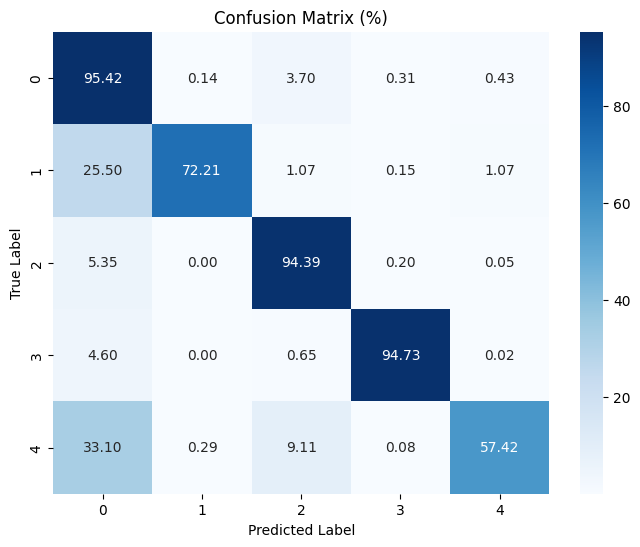

In [8]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import DataLoader

# Load test dataset


class LandcoverAIDataset(Dataset):
    def __init__(self, csv_file):
        # Read CSV file
        self.data = pd.read_csv("/kaggle/input/computervision/test_meta1.csv")
        print(f"Loaded {len(self.data)} samples from {csv_file}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row["image_path"]
        gt_path = row["groundtruth_path"]
        
        # Read image and convert to RGB
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        # Simplified image preprocessing
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        
        # Read ground truth (mask) in grayscale
        mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Ground truth not found: {gt_path}")
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        
        # Convert to tensors with minimal processing
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).long()
        
        return image, mask



# Load the trained model
def load_model():
    model = get_model()  # Get the model architecture
    model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))  # Load weights
    model.eval()  # Set to evaluation mode
    return model

# Compute accuracy and confusion matrix
def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)["out"]
            preds = torch.argmax(outputs, dim=1)  # Get class with highest probability

            all_preds.append(preds.cpu().numpy().flatten())
            all_labels.append(masks.cpu().numpy().flatten())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (%)")
    plt.show()

# Main function
def main():
    test_dataset = LandcoverAIDataset(TEST_CSV)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    model = load_model()
    evaluate_model(model, test_loader)

if __name__ == "__main__":
    main()